<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/feature-pm/ML_structure_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os 

#first put a shortcut in your drive to the image processing folder

RESULTS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        '4.dehazingDC+DoH(0.0005)+GLCM')


DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(RESULTS_DIR))

results_file = os.listdir(RESULTS_DIR)

['20586908_6c613a14b80a8591_MG_R_CC_ANON_glcm.csv', '20586934_6c613a14b80a8591_MG_L_CC_ANON_glcm.csv', '20586960_6c613a14b80a8591_MG_R_ML_ANON_glcm.csv', '20586986_6c613a14b80a8591_MG_L_ML_ANON_glcm.csv', '20587054_b6a4f750c6df4f90_MG_R_CC_ANON_glcm.csv', '20587080_b6a4f750c6df4f90_MG_R_ML_ANON_glcm.csv', '20587148_fd746d25eb40b3dc_MG_R_CC_ANON_glcm.csv', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON_glcm.csv', '20587200_fd746d25eb40b3dc_MG_R_ML_ANON_glcm.csv', '20587226_fd746d25eb40b3dc_MG_L_ML_ANON_glcm.csv', '20587294_e634830794f5c1bd_MG_R_CC_ANON_glcm.csv', '20587320_e634830794f5c1bd_MG_L_CC_ANON_glcm.csv', '20587346_e634830794f5c1bd_MG_R_ML_ANON_glcm.csv', '20587372_e634830794f5c1bd_MG_L_ML_ANON_glcm.csv', '20587466_d571b5880ad2a016_MG_L_CC_ANON_glcm.csv', '20587492_d571b5880ad2a016_MG_R_ML_ANON_glcm.csv', '20587518_d571b5880ad2a016_MG_L_ML_ANON_glcm.csv', '20587544_d571b5880ad2a016_MG_R_CC_ANON_glcm.csv', '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON_glcm.csv', '20587638_f4b2d377f43ba0bd_MG_

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [57]:
def read_results_train_test(path):
  df_train = pd.DataFrame()
  df_test = pd.DataFrame()
  counter = 0
  for result in results_file:
    if counter < len(results_file)/2:
      try:
        df = pd.read_csv(path+'/'+result)
        df_train= df_train.append(df)
      except:
        print("Empty file ", result)
    else:
      try:
        df = pd.read_csv(path+'/'+result)
        df_test= df_test.append(df)
      except:
        print("Empty file ", result)
    counter += 1
  return df_train, df_test

In [ ]:
# dfs = read_results(RESULTS_DIR)

In [5]:
# dfs

In [ ]:
# dfs.shape

(605444, 29)

In [ ]:
# dfs.label.value_counts()

0    599398
1      6046
Name: label, dtype: int64

In [6]:
# dfs.label.value_counts().idxmax()

# **Preprocessing**

In [7]:
# We will balance data randomly taking  the same amount of 0 and 1 label inputs. There are several options to manage unbalanced data,
# this is just one approach, we should try different approaches.
# https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f
def rus(dfs, not_consider=0):
  df_negative = dfs.loc[dfs.label == dfs.label.value_counts().idxmax()]
  df_0 = df_negative.sample(min(dfs.label.value_counts())-not_consider, random_state = 1)
  df_negative = df_negative.append(df_0).drop_duplicates(keep=False)
  dfs_eq = df_0.append(dfs.loc[dfs.label == 1]) #dfs.label.value_counts().idxmin()
  print("Length of balanced data: ", len(dfs_eq))
  print(dfs_eq['label'].value_counts())
  return dfs_eq, df_negative

In [8]:
def plotFeatures(data):
  #plot the scatter matrix
  pd.plotting.scatter_matrix(data,figsize=(25,25))
  #correlation plot
  corr = data.corr()
  f, ax = plt.subplots(figsize=(25, 25))
  sns.heatmap(corr,annot=True)

In [9]:
def standardScaler(X_train, X_test):
  standard_scaler = preprocessing.StandardScaler()
  X_train = standard_scaler.fit_transform(X_train)
  X_test = standard_scaler.transform(X_test)
  return X_train, X_test

# **Feature Engineering**

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [11]:
def featureSelectionTrees(estimators, X_train, y_train, X_test):
  clf = ExtraTreesClassifier(n_estimators=estimators)
  clf = clf.fit(X_train, y_train)
  model = SelectFromModel(clf, prefit=True)
  X_train = model.transform(X_train)
  X_test = model.transform(X_test)
  return X_train, X_test

In [12]:
def pcaAnalysis(components, X_train, X_test):
  pca = PCA(components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print("PCA variance ratio: ", pca.explained_variance_ratio_)
  print("Total variance Explained by PCA: ", sum(pca.explained_variance_ratio_))
  return X_train, X_test

In [13]:
def selectFeaturesChi(k, X_train, X_test, y_train):
  sel = SelectKBest(chi2, k=k)
  sel.fit(X_train, y_train)
  X_train = sel.transform(X_train)
  X_test = sel.transform(X_test)
  return X_train, X_test

# **Classification**

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



In [15]:
def KNN(neighbors, X_train, X_test, y_train, y_test, data, labels):
  neigh = KNeighborsClassifier(n_neighbors=neighbors)
  y_pred = neigh.fit(X_train, y_train).predict(X_test)
  y_pred_proba = neigh.predict_proba(X_test)
  y_pred_proba = [i[1] if i.argmax == 1 else 1-i[0] for i in y_pred_proba]

  cvScore = cross_val_score(neigh, data, labels, cv=2)
  print(cvScore)
  print("Mean CV_score accuracy: ", np.mean(cvScore))
  return y_pred_proba

In [81]:
def DecisionTree(X_train, X_test, y_train, y_test):
  cvScore = []
  selectedFold = 1
  clf1 = tree.DecisionTreeClassifier()
  y_pred_1 = clf1.fit(X_train, y_train).predict(X_test)

  print('accuracy: ', accuracy_score(y_test, y_pred_1))
  print(classification_report(y_test, y_pred_1))  

  cvScore.append(accuracy_score(y_test, y_pred_1))

  clf2 = tree.DecisionTreeClassifier()
  y_pred_2 = clf2.fit(X_test, y_test).predict(X_train)

  print('accuracy: ', accuracy_score(y_train, y_pred_2))
  print(classification_report(y_train, y_pred_2))  

  cvScore.append(accuracy_score(y_train, y_pred_2))


  # cvScore = cross_val_score(clf, data, labels, cv=2)
  print(cvScore)
  
  print("Mean CV_score accuracy: ", np.mean(cvScore))

  # Choose the best one
  if np.array(cvScore).argmax() == 0:  
    y_pred_proba = clf1.predict_proba(X_test)
    y_pred_proba = [i[1] if i.argmax == 1 else 1-i[0] for i in y_pred_proba]
    
  else:
    y_pred_proba = clf2.predict_proba(X_train)
    y_pred_proba = [i[1] if i.argmax == 1 else 1-i[0] for i in y_pred_proba]
    selectedFold=2
  print(len(y_pred_proba))
  
  return y_pred_proba, selectedFold

In [17]:
# This is an example of how to use a Pipe inside a function we are training, as done in Challenge 3 by the professor
def SVC_linear(n_values, lower_value_C, higher_value_C, base, data, labels):
  #Let's apply a stratified 10-fold cross validation
  cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

  #Let's build a pipeline with only a scaler and a linear SVM
  pipe = Pipeline([('scaler', StandardScaler()), ('classifier',SVC(kernel='linear'))])

  #Let's build a structure for the grid search with a set of parameters for the techniques in the pipeline
  #Be careful to the double underscore between the name you chose in the pipeline and the name of the parameter
  #Be careful also to the function logspace for the range of the C values
  parameters={'classifier__C': np.logspace(lower_value_C, higher_value_C, num=n_values,base=base)}
  print(parameters)

  #Let's apply the grid search function
  grid_search = GridSearchCV(pipe, parameters, cv=cv)
  #Let's train and test the learning system
  grid_search.fit(data, labels)

  #Here we just print the best accuracy and the corresponding values for the parameters
  print("The best parameters are %s with an accuracy of %0.4f"%(grid_search.best_params_, grid_search.best_score_))


In [18]:
def SVM_SEL(n_values, lower_value_C, higher_value_C, data, labels):
  C_range = [1, 3, 5] #np.logspace(lower_value_C, higher_value_C, n_values)
  gamma_range = [2.5, 5, 10] #np.logspace(-9, 3, 13)
  kernel_option = ['rbf']
  degree_option = [2, 3]
  param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_option, degree=degree_option)
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
  grid.fit(data, labels)

  print("The best parameters are %s with an accuracy of %0.4f"%(grid.best_params_, grid.best_score_))
  return grid.best_params_

In [ ]:
  dfs = read_results(RESULTS_DIR)


# **Scores**

In [19]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(DATA_DIR))

['normals.txt', 'images', 'groundtruths', 'masks']


In [ ]:
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

In [ ]:
# function to get connected components of the ground truth binary image
import cv2

def componentsStatsGroundTruth(matrix):
  dict_stat = dict()

  # getting the info of the components in the ground truth
  # second value is connectivity 4 or 8
  connectedComponentsGroundTruth = cv2.connectedComponentsWithStats(matrix, 8, cv2.CV_32S)

  # Get the results
  # The first cell is the number of labels
  num_labels = connectedComponentsGroundTruth[0]
  # The second cell is the label matrix
  labels = connectedComponentsGroundTruth[1]
  
  
  # The third cell is the stat matrix

# if it is not register as normal
# stat have 5 items: leftmost x coordinate,
#                    topmost y coordinate,
#                    horizontal size of the bounding box
#                    vertical size of the bounding box
#                    total area in pixels of the connected component

  stats = connectedComponentsGroundTruth[2]
  for stat in range(len(stats)):
    dict_stat[stat] = {}
    dict_stat[stat]["leftmost_x"] = stats[stat][0]
    dict_stat[stat]["topmost_y"] = stats[stat][1]
    dict_stat[stat]["hor_size"] = stats[stat][2]
    dict_stat[stat]["vert_size"] = stats[stat][3]
    dict_stat[stat]["total_ares"] = stats[stat][4]

  # The fourth cell is the centroid matrix
  dict_centroid = dict()
  centroids = connectedComponentsGroundTruth[3]
  for i in range(len(centroids)):
    dict_centroid[i] = {}
    dict_centroid[i]["x"] = centroids[i][0]
    dict_centroid[i]["y"] = centroids[i][1]

  return num_labels, labels, dict_stat, dict_centroid

In [ ]:
import pandas as pd
import gc
import json

gTComponents = pd.DataFrame()
flag = True

for groundTruth in groundTruths:

  gTComponents = pd.DataFrame()

  imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', groundTruth), cv2.IMREAD_GRAYSCALE)

  num_labels, labels, stats, centroids = componentsStatsGroundTruth(imgGroundTruth)
  
  # if it is not register as normal
  # stat have 5 items: leftmost x coordinate,
  #                    topmost y coordinate,
  #                    horizontal size of the bounding box
  #                    vertical size of the bounding box
  #                    total area in pixels of the connected component

  gTComponents['stats'] = [stats] 
  gTComponents['centroids'] = [centroids]
  gTComponents['num_labels'] = num_labels
  gTComponents['name'] = groundTruth

  if(flag):
    gTComponents.to_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'groundTruthStats.csv'),
                    mode='a',
                    index=False)
    flag = False
  else:
    gTComponents.to_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'groundTruthStats.csv'),
                  mode='a',
                  header=False,
                  index=False)
  
  del num_labels, labels, stats, centroids
  gc.collect()


In [41]:
df = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'groundTruthStats.csv'))
df

,stats,centroids,num_labels,name
0,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1279.364551254805, 'y': 1663.3963571...",3,20587372_e634830794f5c1bd_MG_L_ML_ANON.tif
1,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1278.8515924175804, 'y': 1663.522784...",103,20587544_d571b5880ad2a016_MG_R_CC_ANON.tif
2,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.5, 'y': 2041.5}}",1,20588680_036aff49b8ac84f0_MG_L_ML_ANON.tif
3,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.5364547039194, 'y': 2041.507374...",5,22427705_d713ef5849f98b6c_MG_L_CC_ANON.tif
4,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1279.6200724933303, 'y': 1663.425047...",32,22580576_2a5b932da4ce5ca1_MG_L_ML_ANON.tif
...,...,...,...,...
406,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.5, 'y': 2041.5}}",1,22670620_e15a16f87b4f9782_MG_R_CC_ANON.tif
407,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1279.4804448250622, 'y': 1663.501196...",5,22613918_f23fa352e7de3dc7_MG_R_CC_ANON.tif
408,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.4276324304342, 'y': 2041.466925...",15,53580885_51bec6477a7898b9_MG_R_CC_ANON.tif
409,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.4678036509797, 'y': 2041.518066...",9,50994535_de4c34099d6ef8de_MG_R_ML_ANON.tif


In [45]:
len(df.loc[df.num_labels == 1])

98

In [46]:
df.loc[ ['20587372', '20587544'] in df.name]
df.loc[df.name.str.contains() ]

,stats,centroids,num_labels,name
0,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1279.364551254805, 'y': 1663.3963571...",3,20587372_e634830794f5c1bd_MG_L_ML_ANON.tif
1,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1278.8515924175804, 'y': 1663.522784...",103,20587544_d571b5880ad2a016_MG_R_CC_ANON.tif
2,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.5, 'y': 2041.5}}",1,20588680_036aff49b8ac84f0_MG_L_ML_ANON.tif
3,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1663.5364547039194, 'y': 2041.507374...",5,22427705_d713ef5849f98b6c_MG_L_CC_ANON.tif
4,"{0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...","{0: {'x': 1279.6200724933303, 'y': 1663.425047...",32,22580576_2a5b932da4ce5ca1_MG_L_ML_ANON.tif


In [ ]:
dfs.loc[dfs.name.str.contains(df.name.iloc[0][:-4], regex=False)]

,name,label,x,y,sigma,contrast10.0,dissimilarity10.0,homogeneity10.0,energy10.0,correlation10.0,...,homogeneity190.0,energy190.0,correlation190.0,ASM190.0,contrast1135.0,dissimilarity1135.0,homogeneity1135.0,energy1135.0,correlation1135.0,ASM1135.0
0,patch_0_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,880.0,1997.0,10.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
1,patch_1_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,0.0,2845.0,4.0,0.119048,0.119048,0.940476,0.864223,0.305614,...,0.950549,0.840713,0.51642,0.706799,0.115385,0.115385,0.942308,0.865551,0.322125,0.749178
2,patch_2_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,0.0,143.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
3,patch_3_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,1.0,678.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4,patch_4_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,0.0,1481.0,4.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,patch_676_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,0.0,1359.0,30.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
677,patch_677_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,604.0,1846.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
678,patch_678_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,31.0,697.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
679,patch_679_20587372_e634830794f5c1bd_MG_L_ML_ANON,0,153.0,323.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


In [72]:

def calculateFROC(groundTruthsDataFrame, normals, candidates, prediction, model, pipeline):

  # evaluation froc curve #

  fn = 0 # false negative, for the blobs that do not belong to any component

  rowListdfROC = []


  candidates_copy= candidates.copy()
  candidates_copy['prediction'] = prediction



  for index, row in groundTruthsDataFrame.iterrows():
    imageKey = row['name'].split('_')[0]

    # list of features found with y,x and sigma
    candidatesImg = candidates_copy.loc[candidates_copy.name.str.contains(row['name'][:-4], regex=False)]


    if row.num_labels > 1 :
      for gtComponent in range(row.num_labels-1):
        matches = []

        for index2, candidate in candidatesImg.iterrows():

          # is the image a normal image?
          if (imageKey in normals):
              rowListdfROC.append(['FP', candidate.prediction])

              continue
          
          stat = eval(row.stats)[gtComponent+1]

          # top left is the 0,0 of the image
          
          left = stat['leftmost_x']
          right = stat['leftmost_x'] + stat['hor_size']

          top = stat['topmost_y']
          bottom = stat['topmost_y'] + stat['vert_size']

          if ( candidate.x >= left ) and ( candidate.x <= right ) and ( candidate.y >= top ) and ( candidate.y <= bottom ): #This is to find if the candidate is whithin the groundtruth component
            matches.append(candidate.prediction)

        if len(matches) == 1:
          rowListdfROC.append(['TP', matches[0]])
        elif len(matches) > 1:
          rowListdfROC.append(['TP', max(matches)])
        else:
          fn = fn+1

  dfROC = pd.DataFrame(rowListdfROC, columns=['type', 'prob'])

  dfROC.to_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'FROC_calculations_{}_pip{}_fn{}_normals{}.csv'.format(model, pipeline, fn, len(normals))))
  
  return fn, dfROC

In [18]:
df['stats'][0]

NameError: ignored

In [68]:

def calculateFROC(groundTruthsDataFrame, normals, candidates, prediction, model, pipeline):

  evaluationList = []
  # evaluation froc curve #

  fn = 0 # false negative, for the blobs that do not belong to any component



  rowListdfROC = []


  candidates_copy= candidates.copy()
  candidates_copy['prediction'] = prediction



  for index, row in groundTruthsDataFrame.iterrows():
    imageKey = row['name'].split('_')[0]

    # list of features found with y,x and sigma
    candidatesImg = candidates_copy.loc[candidates_copy.name.str.contains(row['name'][:-4], regex=False)]
    candidates_number = len(candidatesImg)



    if row.num_labels > 1 :
      positive_candidates = 0

      for gtComponent in range(row.num_labels-1):
        matches = []

        for index2, candidate in candidatesImg.iterrows():

          # is the image a normal image?
          if (imageKey in normals):
              rowListdfROC.append(['FP', candidate.prediction])

              continue
          
          stat = eval(row.stats)[gtComponent+1]

          # top left is the 0,0 of the image
          
          left = stat['leftmost_x']
          right = stat['leftmost_x'] + stat['hor_size']

          top = stat['topmost_y']
          bottom = stat['topmost_y'] + stat['vert_size']

          if ( candidate.x >= left ) and ( candidate.x <= right ) and ( candidate.y >= top ) and ( candidate.y <= bottom ): #This is to find if the candidate is whithin the groundtruth component
            matches.append(candidate.prediction)

        if len(matches) == 1:
          rowListdfROC.append(['TP', matches[0]])
          positive_candidates += 1
        elif len(matches) > 1:
          rowListdfROC.append(['TP', max(matches)])
          positive_candidates += 1
        else:
          fn = fn+1

    evaluationList.append([imageKey, row.num_labels-1, candidates_number, positive_candidates])
  


  dfROC = pd.DataFrame(rowListdfROC, columns=['type', 'prob'])

  dfROC.to_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'FROC_calculations_{}_pip{}_fn{}_normals{}.csv'.format(model, pipeline, fn, len(normals))))

  
  return fn, dfROC, 

In [ ]:

#Preprocessing steps
#Manage unbalanced data
dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

labels = dataBalanced['label']
data = dataBalanced.drop(['name', 'label'], axis=1)
data

Length of balanced data:  3536
0    1768
1    1768
Name: label, dtype: int64


,contrast10.0,dissimilarity10.0,homogeneity10.0,energy10.0,correlation10.0,ASM10.0,contrast145.0,dissimilarity145.0,homogeneity145.0,energy145.0,...,homogeneity190.0,energy190.0,correlation190.0,ASM190.0,contrast1135.0,dissimilarity1135.0,homogeneity1135.0,energy1135.0,correlation1135.0,ASM1135.0
74,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
27,0.003955,0.003955,0.998023,0.991540,0.693662,0.983151,0.008618,0.008618,0.995691,0.989105,...,0.997175,0.990693,0.562374,0.981472,0.006320,0.006320,0.996840,0.990249,0.518558,0.980593
0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
46,0.045249,0.045249,0.977376,0.946286,0.262350,0.895457,0.044289,0.044289,0.977855,0.946952,...,0.988777,0.958796,0.618523,0.919290,0.048951,0.048951,0.975524,0.944718,0.197131,0.892491
0,0.005650,0.005650,0.997175,0.993794,0.163832,0.987626,0.006320,0.006320,0.996840,0.993403,...,0.996893,0.993513,0.080215,0.987067,0.006320,0.006320,0.996840,0.993403,0.080162,0.986849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
6,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
7,0.065789,0.065789,0.967105,0.712376,0.854315,0.507479,0.091413,0.091413,0.954294,0.688504,...,0.957895,0.693530,0.815147,0.480983,0.108033,0.108033,0.945983,0.678704,0.765916,0.460639
10,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
dfs = read_results(RESULTS_DIR)

In [39]:
dfs.label.value_counts()

0    600218
1      6140
Name: label, dtype: int64

In [ ]:
zeros = pd.DataFrame(np.array(zeros).reshape(1,24), columns = data.columns)
data.append(zeros)

,contrast10.0,dissimilarity10.0,homogeneity10.0,energy10.0,correlation10.0,ASM10.0,contrast145.0,dissimilarity145.0,homogeneity145.0,energy145.0,...,homogeneity190.0,energy190.0,correlation190.0,ASM190.0,contrast1135.0,dissimilarity1135.0,homogeneity1135.0,energy1135.0,correlation1135.0,ASM1135.0
74,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
27,0.003955,0.003955,0.998023,0.991540,0.693662,0.983151,0.008618,0.008618,0.995691,0.989105,...,0.997175,0.990693,0.562374,0.981472,0.006320,0.006320,0.996840,0.990249,0.518558,0.980593
0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
46,0.045249,0.045249,0.977376,0.946286,0.262350,0.895457,0.044289,0.044289,0.977855,0.946952,...,0.988777,0.958796,0.618523,0.919290,0.048951,0.048951,0.975524,0.944718,0.197131,0.892491
0,0.005650,0.005650,0.997175,0.993794,0.163832,0.987626,0.006320,0.006320,0.996840,0.993403,...,0.996893,0.993513,0.080215,0.987067,0.006320,0.006320,0.996840,0.993403,0.080162,0.986849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
7,0.065789,0.065789,0.967105,0.712376,0.854315,0.507479,0.091413,0.091413,0.954294,0.688504,...,0.957895,0.693530,0.815147,0.480983,0.108033,0.108033,0.945983,0.678704,0.765916,0.460639
10,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
14,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


# **Main**

In [ ]:
# def main():

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import copy

classifier = ''

#Reading data
dfs_train, dfs_test = read_results_train_test(RESULTS_DIR)

#Preprocessing steps
#Manage unbalanced data
# dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

y_train = dfs_train['label'].reset_index(drop=True)
candidates_train = dfs_train[['name', 'label', 'x', 'y', 'sigma']]
X_train = dfs_train.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)

y_test = dfs_test['label'].reset_index(drop=True)
candidates_test = dfs_test[['name', 'label', 'x', 'y', 'sigma']]
X_test = dfs_test.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)


#Plot features 
#  plotFeatures(data)

#Obtain train-test datasets
if classifier == "SVM_SEL":
  counter = 0
  print('Len of negative pool: ',len(dfNegative))
  X_train, X_test, y_train, y_test, candidates_train, candidates_test = train_test_split(data, labels, candidates, test_size=0.5,  stratify=labels,random_state=42)  

  # Normalization steps
  X_train, X_test = standardScaler(X_train, X_test)

  #Feature Engineering - PCA, LDA, choose-k, etc
  # X_train, X_test = pcaAnalysis(10, X_train, X_test)

  trainDataFull = pd.DataFrame(X_train)
  print(trainDataFull)
  trainDataFull['label'] = y_train

  dataBalanced, dfNegative = rus(trainDataFull)

#  while len(dfNegative)>(len(dataBalanced)/2)
  while True:

    #Classification

    trainBalanceData = dataBalanced.drop('label', axis=1)
    trainBalanceLabel = dataBalanced['label']

    if counter == 0:
      print("Trying SMV SEL...")
      best_params = SVM_SEL(13, -2, 10, trainBalanceData, trainBalanceLabel)
      clf = SVC(**best_params)

    clf.fit(trainBalanceData, trainBalanceLabel)
    pred = clf.predict(dfNegative.drop('label', axis=1))

    y_pred = clf.predict(X_test)
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    cvScore = cross_val_score(clf, data, labels, cv=2)
    print(cvScore)
    print("Mean CV_score accuracy: ", np.mean(cvScore))


    misclassified = pd.DataFrame(columns = data.columns)
    labels_pool = []
    for i in range(len(pred)):
      if (pred[i]==1) & (dfNegative['label'].iloc[i] == 0): #FP False positive
#        new_row = pd.DataFrame(X_test[i].reshape(1, data.shape[1] ), columns=data.columns)
        new_row = dfNegative.drop('label', axis=1).iloc[i]
        misclassified = misclassified.append(new_row)
        labels_pool.append(dfNegative['label'].iloc[i])

    newData_1 = dataBalanced.loc[dataBalanced.label == 1]

    dataBalanced, dfNegative = rus(newData_1.append(dfNegative), len(misclassified))
    trainBalanceLabel = dataBalanced['label'].append(pd.Series(labels_pool))
    trainBalanceData = dataBalanced.drop(['label'], axis=1).append(misclassified)
    print('Data len: ', len(data))
    print('labels len: ', len(labels))
    counter +=1

else:

  dataBalanced, dfNegative = rus(dfs_train) #Random majority undersampling

  y_train = dfs_train['label'].reset_index(drop=True)
  X_train = dfs_train.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)  
  candidates_train = dfs_train[['name', 'label', 'x', 'y', 'sigma']]

  # Normalization steps
  X_train, X_test = standardScaler(X_train, X_test)


  # SVC_linear(5, -2,2, 10, data, labels)
  predDT, selectedFold = DecisionTree(X_train, X_test, y_train, y_test)
#  predKNN = KNN(5, X_train, X_test, y_train, y_test, data, labels)


  groundTruthsDataFrame = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'groundTruthStats.csv'))
  

  

  # read numbers of normal images
  normals = []
  with open(os.path.join(DATA_DIR,'normals.txt')) as f:
      for line in f:
          normals.append(line[:-1])

  if selectedFold == 1:
    candidates_unique = [cand.split('_')[2] for cand in candidates_test.name.values.tolist()]
  else:
    candidates_unique = [cand.split('_')[2] for cand in candidates_train.name.values.tolist()]
  candidates_unique = list(set(candidates_unique))
  df_candidates_unique = pd.DataFrame()
  df_candidates_unique['key'] = candidates_unique

  groundTruthsDataFrame['key'] = [i.split('_')[0] for i in groundTruthsDataFrame.name.values.tolist()]
  
  groundTruthsDataFrame.join(df_candidates_unique.set_index('key'), on='key', how='right')

  normals = [i for i in normals if i in candidates_unique]

  calculateFROC(groundTruthsDataFrame, normals, candidates_test, predDT, 'DT', '4')




Length of balanced data:  5220
0    2610
1    2610
Name: label, dtype: int64
accuracy:  0.9914012790328055
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    367688
           1       0.73      0.15      0.25      3530

    accuracy                           0.99    371218
   macro avg       0.86      0.58      0.62    371218
weighted avg       0.99      0.99      0.99    371218

accuracy:  0.9890660882878285
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    232530
           1       0.53      0.16      0.24      2610

    accuracy                           0.99    235140
   macro avg       0.76      0.58      0.62    235140
weighted avg       0.99      0.99      0.99    235140

[0.9914012790328055, 0.9890660882878285]
Mean CV_score accuracy:  0.9902336836603169
371218


In [80]:
a = [0.991409360537474, 0.9889852853619121]
np.array(a).argmax()

0

In [67]:
len(df_candidates_unique)

205

In [ ]:
# def main():

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import copy

classifier = ''

#Reading data
dfs_train, dfs_test = read_results_train_test(RESULTS_DIR)

#Preprocessing steps
#Manage unbalanced data
# dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

labels = dfs_train['label'].reset_index(drop=True)
candidates = dfs_train[['name', 'label', 'x', 'y', 'sigma']]
data = dfs_train.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)

#Plot features 
#  plotFeatures(data)

#Obtain train-test datasets
if classifier == "SVM_SEL":
  counter = 0
  print('Len of negative pool: ',len(dfNegative))
  X_train, X_test, y_train, y_test, candidates_train, candidates_test = train_test_split(data, labels, candidates, test_size=0.5,  stratify=labels,random_state=42)  

  # Normalization steps
  X_train, X_test = standardScaler(X_train, X_test)

  #Feature Engineering - PCA, LDA, choose-k, etc
  # X_train, X_test = pcaAnalysis(10, X_train, X_test)

  trainDataFull = pd.DataFrame(X_train)
  print(trainDataFull)
  trainDataFull['label'] = y_train

  dataBalanced, dfNegative = rus(trainDataFull)

#  while len(dfNegative)>(len(dataBalanced)/2)
  while True:

    #Classification

    trainBalanceData = dataBalanced.drop('label', axis=1)
    trainBalanceLabel = dataBalanced['label']

    if counter == 0:
      print("Trying SMV SEL...")
      best_params = SVM_SEL(13, -2, 10, trainBalanceData, trainBalanceLabel)
      clf = SVC(**best_params)

    clf.fit(trainBalanceData, trainBalanceLabel)
    pred = clf.predict(dfNegative.drop('label', axis=1))

    y_pred = clf.predict(X_test)
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    cvScore = cross_val_score(clf, data, labels, cv=2)
    print(cvScore)
    print("Mean CV_score accuracy: ", np.mean(cvScore))


    misclassified = pd.DataFrame(columns = data.columns)
    labels_pool = []
    for i in range(len(pred)):
      if (pred[i]==1) & (dfNegative['label'].iloc[i] == 0): #FP False positive
#        new_row = pd.DataFrame(X_test[i].reshape(1, data.shape[1] ), columns=data.columns)
        new_row = dfNegative.drop('label', axis=1).iloc[i]
        misclassified = misclassified.append(new_row)
        labels_pool.append(dfNegative['label'].iloc[i])

    newData_1 = dataBalanced.loc[dataBalanced.label == 1]

    dataBalanced, dfNegative = rus(newData_1.append(dfNegative), len(misclassified))
    trainBalanceLabel = dataBalanced['label'].append(pd.Series(labels_pool))
    trainBalanceData = dataBalanced.drop(['label'], axis=1).append(misclassified)
    print('Data len: ', len(data))
    print('labels len: ', len(labels))
    counter +=1

else:

  dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

  labels = dataBalanced['label'].reset_index(drop=True)
  data = dataBalanced.drop(['name', 'label'], axis=1).reset_index(drop=True)  
  candidates = dataBalanced[['name', 'label', 'x', 'y', 'sigma']]

  X_train, X_test, y_train, y_test, candidates_train, candidates_test = train_test_split(data, labels, candidates, test_size=0.5,  shuffle=False, random_state=42)  

  # Normalization steps
  X_train, X_test = standardScaler(X_train, X_test)


  # SVC_linear(5, -2,2, 10, data, labels)
  predDT = DecisionTree(X_train, X_test, y_train, y_test, data, labels)
  predKNN = KNN(5, X_train, X_test, y_train, y_test, data, labels)


  groundTruthsDataFrame = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'groundTruthStats.csv'))
  

  

  # read numbers of normal images
  normals = []
  with open(os.path.join(DATA_DIR,'normals.txt')) as f:
      for line in f:
          normals.append(line[:-1])

  candidates_unique = [cand.split('_')[2] for cand in candidates_test.name.values.tolist()]
  candidates_unique = list(set(candidates_unique))
  df_candidates_unique = pd.DataFrame()
  df_candidates_unique['key'] = candidates_unique

  groundTruthsDataFrame['key'] = [i.split('_')[0] for i in groundTruthsDataFrame.name.values.tolist()]

groundTruthsDataFrame.join(df_candidates_unique.set_index('key'), on='key', how='right')





  # calculateFROC(groundTruthsDataFrame, normals, candidates_test, predKNN, 'KNN', '4')




In [50]:
df_candidates_unique

,key
0,22580576
1,53582764
2,24065407
3,24065734
4,22427682
...,...
302,51049276
303,50997651
304,50994535
305,50996228


In [25]:
  dfROC = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'FROC_calculations_{}_pip{}_{}.csv'.format('KNN', '4', 5296)), index_col=0)

In [30]:
import matplotlib.pyplot as plt


fn = 5296
tpc = 0
fpc = 0
normals = len(dfROC.loc[dfROC.type == 'FP'])

tpr = []
fppi = []

dfROC = dfROC.sort_values('prob', ascending=False)
tp = len(dfROC.loc[dfROC.type == 'TP'])

for index, row in dfROC.iterrows():
  if row.type == 'TP':
    tpc += 1  
  else:
    fpc +=1

  tpr.append( tpc/(tp+fn) )
  fppi.append( fpc/normals )





NameError: ignored

In [40]:
tp+fn

6595

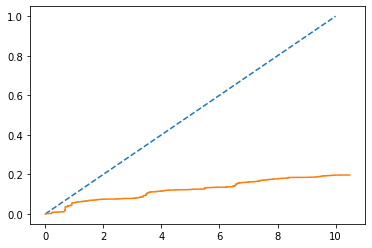

In [33]:
import matplotlib.pyplot as plt

plt.plot([0,10], [0,1], linestyle="--")
plt.plot(fppi, tpr)

In [71]:
lista = []
for i in predKNN:
  print(i)
  if i.argmax==1:
    lista.append(i[1])
  else:
    lista.append(1-i[0])
  print(lista)

[1. 0.]
[0.0]
[0.2 0.8]
[0.0, 0.8]
[1. 0.]
[0.0, 0.8, 0.0]
[0.2 0.8]
[0.0, 0.8, 0.0, 0.8]
[0. 1.]
[0.0, 0.8, 0.0, 0.8, 1.0]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0]
[0. 1.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0. 1.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0. 1.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
[0.4 0.6]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.6]
[1. 0.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.6, 0.0]
[0. 1.]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.6, 0.0, 1.0]
[0.2 0.8]
[0.0, 0.8, 0.0, 0.8, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [69]:
lista

[0.0,
 0.8,
 0.0,
 0.8,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.6,
 0.0,
 1.0,
 0.8,
 0.0,
 0.8,
 1.0,
 0.0,
 0.0,
 0.4,
 0.0,
 1.0,
 0.19999999999999996,
 1.0,
 1.0,
 0.6,
 0.0,
 1.0,
 0.6,
 1.0,
 0.19999999999999996,
 1.0,
 1.0,
 0.0,
 0.6,
 1.0,
 0.0,
 0.6,
 0.6,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.8,
 0.0,
 0.4,
 0.6,
 1.0,
 0.0,
 0.0,
 0.19999999999999996,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.19999999999999996,
 0.19999999999999996,
 1.0,
 0.6,
 1.0,
 0.8,
 1.0,
 0.4,
 0.19999999999999996,
 0.0,
 0.8,
 1.0,
 0.0,
 1.0,
 0.4,
 0.0,
 0.8,
 0.0,
 0.0,
 0.0,
 1.0,
 0.8,
 0.19999999999999996,
 0.0,
 0.8,
 0.0,
 1.0,
 0.0,
 1.0,
 0.8,
 1.0,
 0.0,
 0.19999999999999996,
 0.0,
 0.0,
 1.0,
 1.0,
 0.8,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6,
 0.0,
 1.0,
 1.0,
 0.0,
 0.8,
 0.0,
 0.19999999999999996,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8,
 1.0,
 0.0,
 1.0,
 0.6,
 0.8,
 0.0,
 1.0,
 0.0,
 1.0,
 0.8,
 0.0,
 0.8,
 0.0

In [34]:
for index, row in groundTruthsDataFrame.iterrows():
  print(row)
  print(row['name'])
  print(row.num_labels)
  break

stats         {0: {'leftmost_x': 0, 'topmost_y': 0, 'hor_siz...
centroids     {0: {'x': 1279.364551254805, 'y': 1663.3963571...
num_labels                                                    3
name                 20587372_e634830794f5c1bd_MG_L_ML_ANON.tif
Name: 0, dtype: object
20587372_e634830794f5c1bd_MG_L_ML_ANON.tif
3


In [ ]:
misclassified

NameError: ignored

In [ ]:
if __name__== "__main__":
  main()

In [ ]:
# When we find the best fit, we can put everything into a pipeline

pipe = Pipeline([('standard', StandardScaler()),
                 ('classifier', KNeighborsClassifier(n_neighbors=5))])

pipe.fit(X_train, y_train)
score = pipe.predict(X_test)
accuracy_score(y_test, score)